In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [3]:
!unzip "/content/drive/MyDrive/Dataset3.zip"

Archive:  /content/drive/MyDrive/Dataset3.zip
  inflating: trashify-image-dataset/metal/20200331_112828.jpg  
  inflating: trashify-image-dataset/metal/20200331_112837.jpg  
  inflating: trashify-image-dataset/metal/20200331_112840.jpg  
  inflating: trashify-image-dataset/metal/20200331_112940.jpg  
  inflating: trashify-image-dataset/metal/20200331_112944.jpg  
  inflating: trashify-image-dataset/metal/20200331_113010.jpg  
  inflating: trashify-image-dataset/metal/20200331_113019.jpg  
  inflating: trashify-image-dataset/metal/20200331_113023.jpg  
  inflating: trashify-image-dataset/metal/20200331_113042.jpg  
  inflating: trashify-image-dataset/metal/20200331_113043.jpg  
  inflating: trashify-image-dataset/metal/20200331_113129.jpg  
  inflating: trashify-image-dataset/metal/20200331_113131.jpg  
  inflating: trashify-image-dataset/metal/20200331_113420.jpg  
  inflating: trashify-image-dataset/metal/20200331_113428.jpg  
  inflating: trashify-image-dataset/metal/20200331_113611.

In [4]:
data_dir = "trashify-image-dataset"

In [5]:
transform = transforms.Compose([
      transforms.Resize((227,227)),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
      transforms.RandomHorizontalFlip(0.3),
      transforms.RandomVerticalFlip(0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

In [6]:
dataset = ImageFolder(data_dir, transform = transform)

Label: metal (Class No: 0)


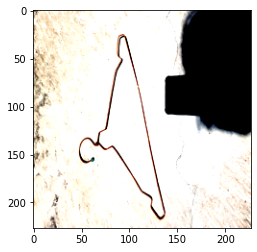

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[10]
show_sample(img, label)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(249, 53, 54)

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32


In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

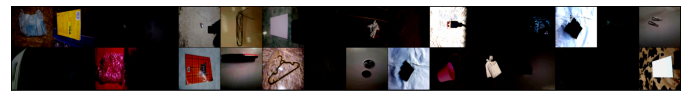

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss.detach(), 'train_acc': acc}

    def testing_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def training_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
       
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
       
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['test_loss'], result['val_loss'], result['train_acc'], result['test_acc'], result['val_acc']))

In [15]:
model = models.vgg16()
num_ftrs = model.classifier[0].in_features
model.fc = nn.Linear(num_ftrs, 2)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
from torch.nn.modules import loss
from torch.optim.adam import Adam
num_epochs = 20
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss();

In [20]:
from torch.autograd import Variable
#Model Training and saving best Model
best_accuracy = 0.0
train_acc_list = []
test_acc_list = []
val_acc_list = []
train_loss_list = []
test_loss_list = []
val_loss_list = []
epo = []
for epoch in range(num_epochs):
  #evaluation and training on training dataset
  model.train()
  train_acc = 0.0
  train_loss = 0.0

  for i, (images, labels) in enumerate(train_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = train_acc / train_size
  train_loss = train_loss / train_size
      
  #Evaluation on testing dataset
  model.eval()

  test_acc = 0.0
  correct1 = 0
  total1 = 0
  test_loss = 0.0

  for i, (images, labels) in enumerate(test_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    test_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    test_acc += int(torch.sum(prediction==labels.data))
    total1 += labels.size(0)
    correct1 += (prediction == labels).sum().item()
  
  test_acc = test_acc / test_size
  test_loss = test_loss / test_size

  val_acc = 0.0
  correct2 = 0
  total2 = 0
  val_loss = 0.0

  for i, (images, labels) in enumerate(val_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    val_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))
    total2 += labels.size(0)
    correct2 += (prediction == labels).sum().item()

  val_loss = val_loss / val_size
  val_acc = val_acc / val_size
  print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+ ' Train Accuracy: '+str(train_acc) + 
                              ' Test Accuracy: '+str(test_acc) + 
                               ' Validation Loss: '+str(val_loss)+ ' Validation Accuracy: '+str(val_acc))
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  val_acc_list.append(val_acc)
  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  val_loss_list.append(val_loss)
  epo.append(epoch+1)

  if(test_acc>best_accuracy):
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = test_acc
print('Test Accuracy of the model on the {} test images: {} %'.format(total1, (correct1 / total1) * 100))
print('Test Accuracy of the model on the {} validation images: {} %'.format(total2, (correct2 / total2) * 100))

Epoch: 1 Train Loss: tensor(4.8645) Train Accuracy: 0.30120481927710846 Test Accuracy: 0.3888888888888889 Validation Loss: tensor(3.5026) Validation Accuracy: 0.4339622641509434
Epoch: 2 Train Loss: tensor(2.5806) Train Accuracy: 0.3493975903614458 Test Accuracy: 0.24074074074074073 Validation Loss: tensor(2.0667) Validation Accuracy: 0.32075471698113206
Epoch: 3 Train Loss: tensor(1.2614) Train Accuracy: 0.3453815261044177 Test Accuracy: 0.37037037037037035 Validation Loss: tensor(1.3160) Validation Accuracy: 0.24528301886792453
Epoch: 4 Train Loss: tensor(1.2143) Train Accuracy: 0.3453815261044177 Test Accuracy: 0.24074074074074073 Validation Loss: tensor(1.1541) Validation Accuracy: 0.32075471698113206
Epoch: 5 Train Loss: tensor(1.1519) Train Accuracy: 0.3493975903614458 Test Accuracy: 0.24074074074074073 Validation Loss: tensor(1.1879) Validation Accuracy: 0.32075471698113206
Epoch: 6 Train Loss: tensor(1.1241) Train Accuracy: 0.30522088353413657 Test Accuracy: 0.37037037037037035

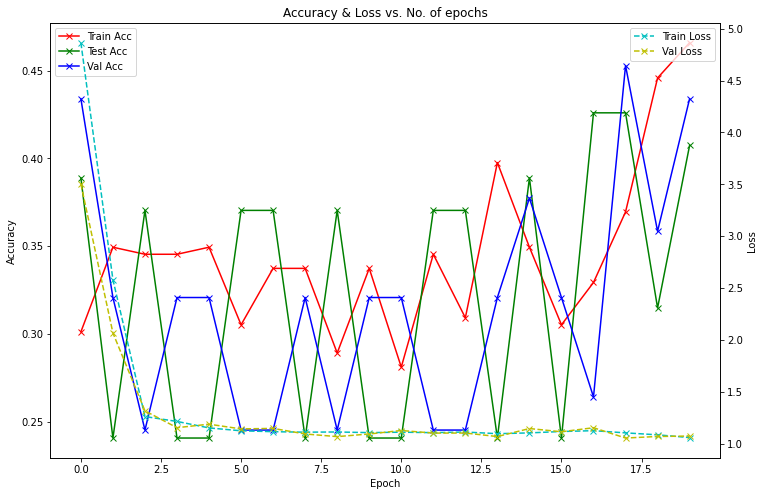

In [23]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
plt.plot(train_acc_list, '-rx', label='Train Acc')
plt.plot(test_acc_list, '-gx', label='Test Acc')
plt.plot(val_acc_list, '-bx', label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#ax.tick_params('vals', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(train_loss_list, '--cx', label='Train Loss')
plt.plot(val_loss_list, '--yx', label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Loss vs. No. of epochs');

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


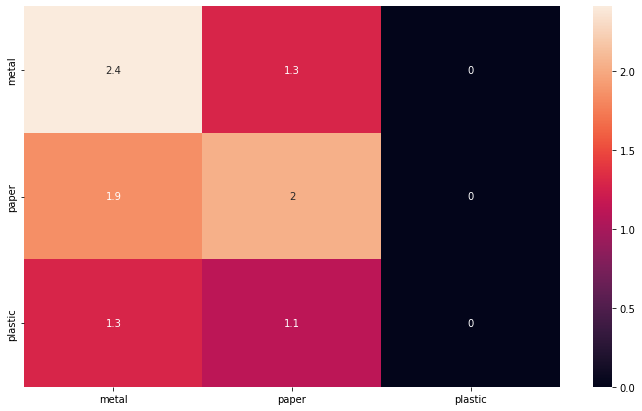

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
        output = model(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('metal', 'paper', 'plastic')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')